<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#GPU-check" data-toc-modified-id="GPU-check-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>GPU check</a></span></li><li><span><a href="#Obtain-the-data" data-toc-modified-id="Obtain-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Obtain the data</a></span></li><li><span><a href="#Examine-the-data" data-toc-modified-id="Examine-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Examine the data</a></span><ul class="toc-item"><li><span><a href="#Data-files" data-toc-modified-id="Data-files-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data files</a></span></li><li><span><a href="#Labels" data-toc-modified-id="Labels-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Labels</a></span></li></ul></li><li><span><a href="#Set-model-creation-parameters" data-toc-modified-id="Set-model-creation-parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Set model creation parameters</a></span></li><li><span><a href="#Define-helper-functions" data-toc-modified-id="Define-helper-functions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define helper functions</a></span></li><li><span><a href="#Create-data-collection" data-toc-modified-id="Create-data-collection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create data collection</a></span></li><li><span><a href="#Create-algorithm" data-toc-modified-id="Create-algorithm-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Create algorithm</a></span></li><li><span><a href="#Find-best-learning-rate" data-toc-modified-id="Find-best-learning-rate-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Find best learning rate</a></span></li><li><span><a href="#Train-last-layer" data-toc-modified-id="Train-last-layer-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Train last layer</a></span></li><li><span><a href="#Train-last-layer-w/-data-augmentation" data-toc-modified-id="Train-last-layer-w/-data-augmentation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Train last layer w/ data augmentation</a></span></li><li><span><a href="#Unfreeze-all-layers---Skip" data-toc-modified-id="Unfreeze-all-layers---Skip-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Unfreeze all layers - Skip</a></span></li><li><span><a href="#Final-training-of-the-model" data-toc-modified-id="Final-training-of-the-model-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Final training of the model</a></span></li><li><span><a href="#Test-Time-Augmentation" data-toc-modified-id="Test-Time-Augmentation-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Test Time Augmentation</a></span></li><li><span><a href="#Examine-prediction-results" data-toc-modified-id="Examine-prediction-results-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Examine prediction results</a></span></li></ul></div>

<h1>Kaggle Dog Breed Identification Challenge</h1>

<img style="float: left; margin-right: 15px;" src="images/dogBreeds.png" />

# Purpose

The purpose of this write-up is to participate in the [Kaggle Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification) challenge, and to explore the creation of a computer vision classification model utilizing transfer learning using the [Fast AI library](https://docs.fast.ai/).

The Kaggle dog breed challenge consists of a canine subset of ImageNet pictures depicting 120 breeds of dogs with a limited number training images per class.  The performance of the model is evaluated against the [Multi Class Log Loss](http://wiki.fast.ai/index.php/Log_Loss) between the predicted probability class label and the true label.

The methodology we'll follow will be:
1. Explore and describe the data
1. Prepare the data
1. Create and train the algorithm
1. Take the resulting model and create predictions against the test set
1. Submit and obtain a Kaggle score against the model's predictive powers

# Notebook setup and imports

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## GPU check

Do a quick check to validate if CUDA GPU support is enabled or not:

In [3]:
# Check for GPU
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


# Dataset operations

## Obtain the data

The data for this notebook can be obtained from Kaggle with the following [Kaggle API](https://github.com/Kaggle/kaggle-api) call:

```bash
kaggle competitions download -c dog-breed-identification
```

## Examine the data

### Data files

Set the path where the data can be found on the disk:

In [4]:
PATH = "./data/dogbreeds/"

Examine the contents of the data directory:

In [5]:
!ls {PATH}

labels.csv	sample_submission.csv.zip  test.zip  train.zip
labels.csv.zip	test			   train


In [6]:
!ls {PATH + '/train'} -U | head -5

d23a9459022b02140e847eea64e05440.jpg
425f6665a1616c4819d20580d09d5e8b.jpg
e81f7ae7181b7efe18eb433b0079bdc0.jpg
8233f609f7a39f0f834894e761d73aa0.jpg
fcee07f3f1190697b6ec35911dcdd8cb.jpg
ls: write error: Broken pipe


In [7]:
print("Number of training images:")
%ls -1 {PATH + '/train'} | wc -l

print("Number of test images:")
%ls -1 {PATH + '/test'} | wc -l

Number of training images:
10222
Number of test images:
10357


### Labels

The labels are kept in a CSV file:

In [8]:
#https://github.com/jupyter/notebook/issues/4369
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

labels = pd.read_csv(PATH + '/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
print("Number of classes:", labels['breed'].nunique())

Number of classes: 120


---
Let's examine the class distribution:

In [10]:
print('Number of observations per class:')
labels.groupby('breed').agg('count')

Number of observations per class:


,id
breed,
affenpinscher,80
afghan_hound,116
african_hunting_dog,86
airedale,107
american_staffordshire_terrier,74
appenzeller,78
australian_terrier,102
basenji,110
basset,82


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fe82bb4e0>]], dtype=object)

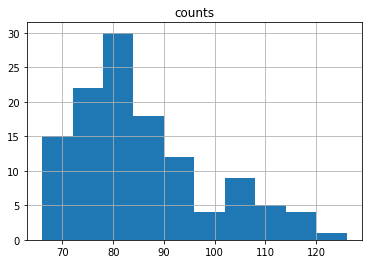

In [11]:
labels.groupby(['breed']).size().reset_index(name='counts').sort_values('counts', ascending=False).hist()

---
Ensure the sizes of the images are similar, or if not what are the sizes?

In [12]:
trainImgs = [i+'.jpg' for i in labels['id']]
trainDims = {k: PIL.Image.open(PATH + '/train/' + k).size for k in trainImgs}

In [13]:
rowSizes, colSizes = list(zip(*trainDims.values()))
rowSizes = np.array(rowSizes)
colSizes = np.array(colSizes)

(array([3.798e+03, 6.259e+03, 1.080e+02, 1.800e+01, 1.100e+01, 4.000e+00, 1.900e+01, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

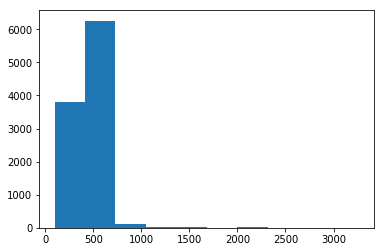

In [14]:
plt.hist(rowSizes)

(array([3.595e+03, 6.395e+03, 1.500e+02, 2.800e+01, 1.800e+01, 2.000e+01, 1.000e+01, 3.000e+00, 0.000e+00, 3.000e+00]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

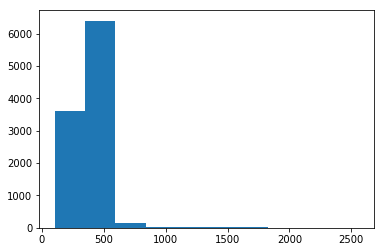

In [15]:
plt.hist(colSizes)

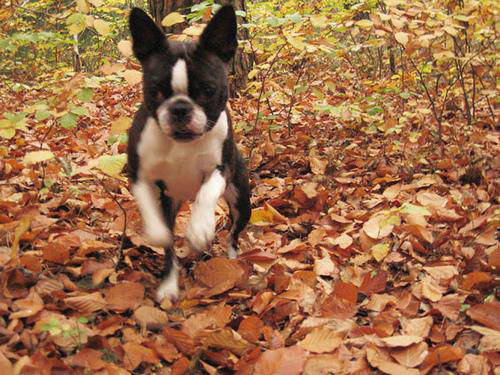

In [16]:
img = PIL.Image.open(PATH + '/train/' + trainImgs[0])
img

The image sizes seem reasonable, and we don't seem to have any gross disparities between the files that need to be resolved. 

# Create the model

Overall process:
* Set precompute=True, so we don't utilize the augmented images
* Use lr_find() to find highest learning rate where loss is still clearly improving
* Train last layer from precomputed activations for 1-2 epochs
* Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
* Unfreeze all layers
* Set earlier layers to 3x-10x lower learning rate than next higher layer
* Use lr_find() again
* Train full network with cycle_mult=2 until over-fitting

## Set model creation parameters

In [20]:
# Set the size we want the images resized to
# Most of ImageNet models are trained on either 224 by 224 or 299 by 299 images
imgSize = 224

# Batch size
# Remember to reduced this if a CUDA out of memory error occurs
batchSize = 32

## Define helper functions

## Create data collection

In [26]:
data = (ImageItemList.from_csv(path=PATH, csv_name='labels.csv', folder='train', suffix='.jpg')
        .random_split_by_pct()
        .label_from_df()
        .transform(get_transforms(), size=imgSize)
        .databunch(bs=batchSize)
        .normalize(imagenet_stats)
       )

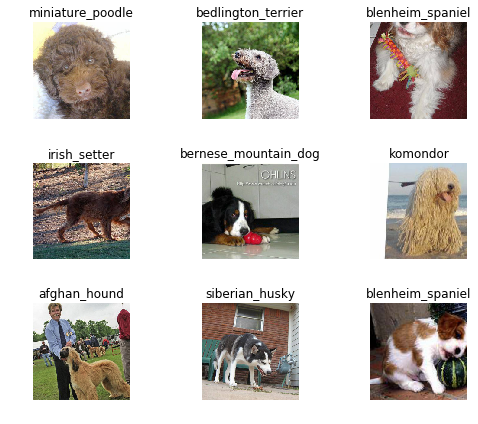

In [44]:
data.show_batch(rows=3, figsize=(7,6))

In [45]:
print(data.classes)
len(data.classes),data.c

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

(120, 120)

## Create model

Next we'll create the model to be trained.

In [48]:
learn = create_cnn(data=data, arch=models.resnet34, metrics=error_rate)

## Find best learning rate

We'll utilize the `lr_find()` function to determine what the optimal learning rate for the algorithm based on the data we're processing:

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Visually inspect the optimal learning rate:

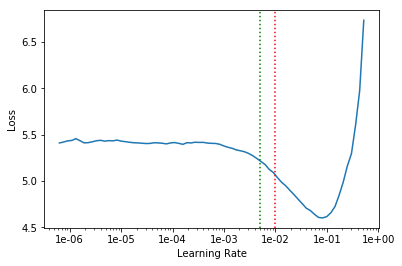

In [54]:
learn.recorder.plot()
plt.axvline(x=1e-2, color="r", linestyle=":")
plt.axvline(x=1e-2/2, color="g", linestyle=":")

In [55]:
# Set the learning rate for use during training
lr = 1e-2/2

## Train last layer

In the beginning only the last layer of the model will be trained.  Because we are utilizing transfer learning from ReNet we don't want to lose all the pre-trained weights in the earlier layers.  We want to leverage and keep the already existing values from earlier in the network, and for now only fine tune the last layers to the features found in our specific images.

In [56]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,error_rate
1,1.668131,1.193753,0.365460
2,1.390331,0.990409,0.297456
3,1.008525,0.677503,0.217710
4,0.645652,0.603784,0.196184


In [58]:
learn.save("head_resnet34_224")

## Examine initial results

Let's examine how the model is doing so far.  This will provide validation the model is moving in the right direction, and if not corrective action can be taken.

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

### Most incorrect

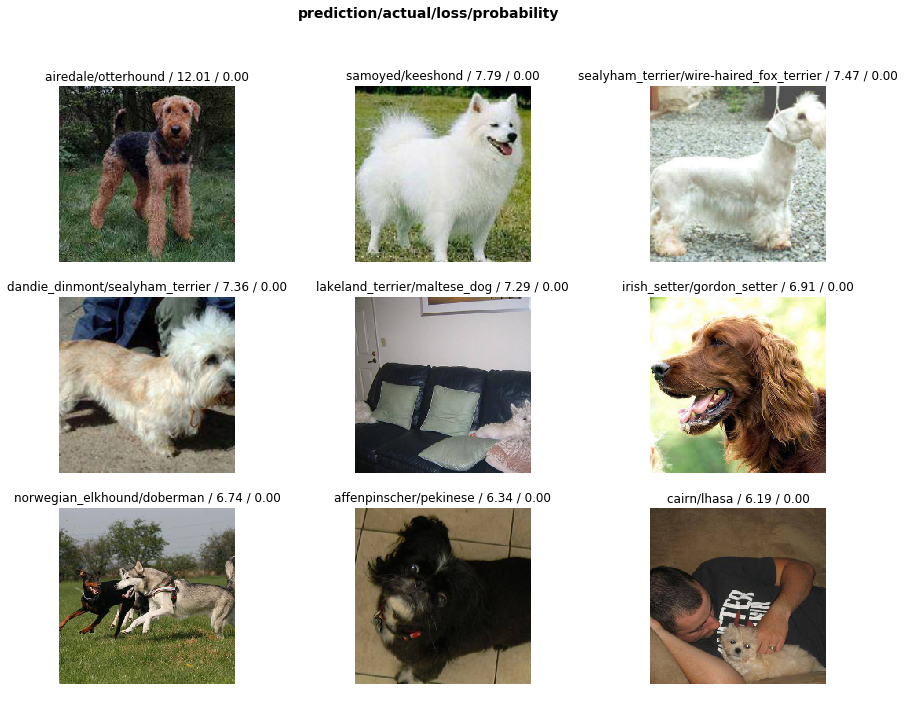

In [65]:
interp.plot_top_losses(9, figsize=(15,11))

### Labels wrong most often

In [63]:
interp.most_confused(min_val=2)

[('eskimo_dog', 'siberian_husky', 7),
 ('silky_terrier', 'australian_terrier', 7),
 ('shetland_sheepdog', 'collie', 6),
 ('walker_hound', 'english_foxhound', 6),
 ('american_staffordshire_terrier', 'staffordshire_bullterrier', 5),
 ('appenzeller', 'entlebucher', 5),
 ('collie', 'border_collie', 5),
 ('siberian_husky', 'eskimo_dog', 5),
 ('greater_swiss_mountain_dog', 'entlebucher', 4),
 ('kelpie', 'dingo', 4),
 ('lhasa', 'shih-tzu', 4),
 ('norwich_terrier', 'norfolk_terrier', 4),
 ('redbone', 'rhodesian_ridgeback', 4),
 ('shih-tzu', 'lhasa', 4),
 ('beagle', 'basset', 3),
 ('bloodhound', 'redbone', 3),
 ('collie', 'shetland_sheepdog', 3),
 ('dingo', 'dhole', 3),
 ('great_pyrenees', 'samoyed', 3),
 ('irish_wolfhound', 'scottish_deerhound', 3),
 ('miniature_poodle', 'toy_poodle', 3),
 ('scottish_deerhound', 'irish_wolfhound', 3),
 ('silky_terrier', 'yorkshire_terrier', 3),
 ('tibetan_mastiff', 'newfoundland', 3),
 ('tibetan_terrier', 'lhasa', 3),
 ('wire-haired_fox_terrier', 'lakeland_ter

So these appear to be breeds that would likely also be misclassified by a human, which is a good indication the model isn't completely missing the mark on obvious items.  Since the model appears to be functioning correctly we'll proceed with further training.

## Recheck learning rate

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


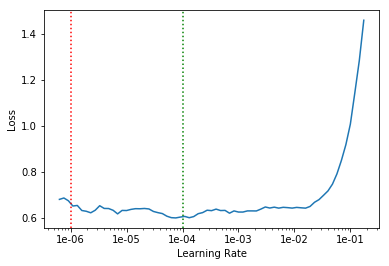

In [73]:
learn.recorder.plot()
plt.axvline(x=1e-6, color="r", linestyle=":")
plt.axvline(x=1e-4, color="g", linestyle=":")

In [74]:
# Set the learning rate for use during training
lr = slice(1e-6,1e-4)

## Train full network

In [75]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.671937,0.597364,0.189824
2,0.604080,0.590440,0.191292


In [76]:
learn.save("full_resnet34_224")

In [77]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.635459,0.575237,0.187378
2,0.553207,0.570541,0.185910


# Predictions

In [41]:
#learn.load("final_224")

## Test Time Augmentation

We'll apply test time augmentation to the validation data before the predictions are made and analyzed:

In [42]:
# The next statement is applied to the VAL data set
log_preds, y = learn.TTA()

## Examine prediction results

In [43]:
# Record probabilities
probs = np.mean(np.exp(log_preds),0)

# Print the accuracy and loss values
print("Accuracy and loss values:")
accuracy_np(probs, y), metrics.log_loss(y, probs)

Accuracy and loss values:


(0.8737769080234834, 0.4116740976322924)

In [44]:
# Get the predictions from the class probs
preds = np.argmax(probs, axis=1)

# Examine the first 10 predictions
print("First 10 predictions:")
preds[:10]

First 10 predictions:


array([19, 15, 19, 99, 73, 79, 21, 38, 10, 26])

Crib more functions from Fast AI to examine the prediction results:

In [45]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

def plot_val_with_title(idxs, title):
    
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    
    pred_classes = [data.classes[preds[x]] for x in idxs]
    true_classes = [data.classes[data.val_y[x]] for x in idxs]
    
    title_classes = ['[Y]: ' + true_classes[i] + '\n' + '[y]: ' + pred_classes[i] for i in range(len(true_classes))]
    
    print(title)
    return plots(imgs, rows=2, titles=title_classes, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

---
View correct results

Correct classifications - First 8


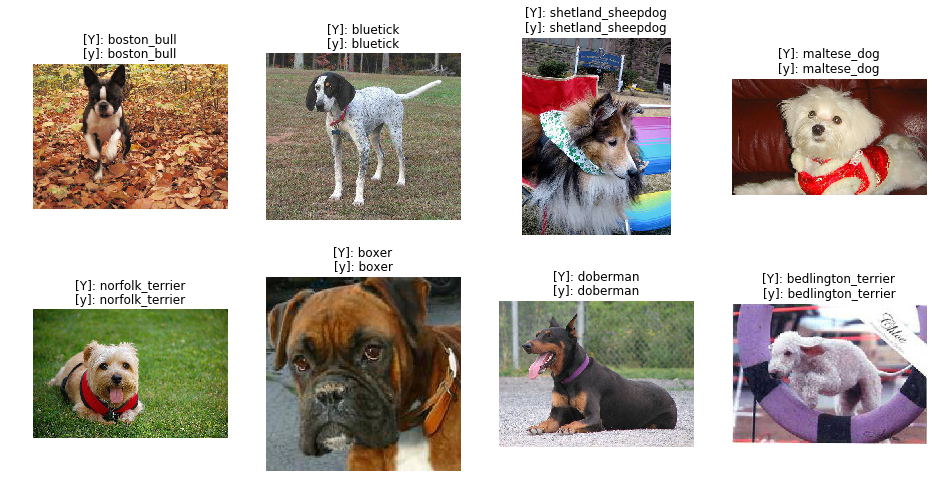

In [46]:
plot_val_with_title(np.where(data.val_y == preds)[0][:8], "Correct classifications - First 8")

---
View incorrect results

Incorrect classifications - First 8


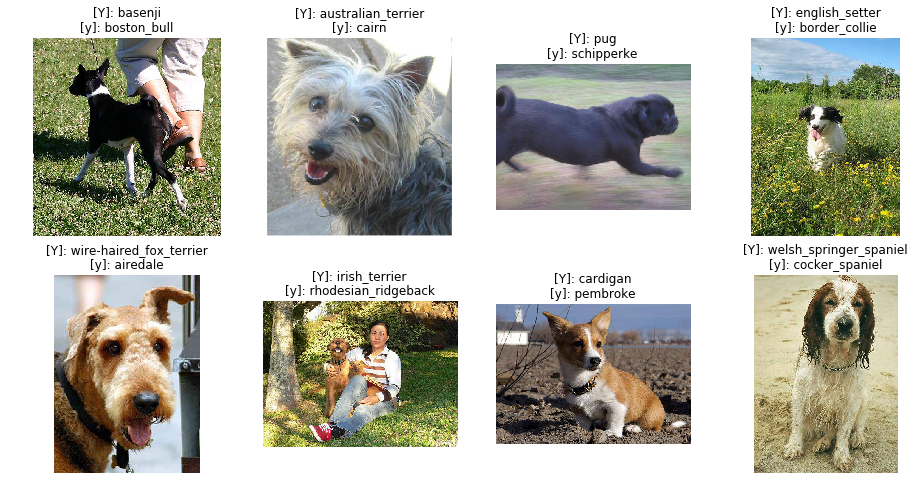

In [47]:
plot_val_with_title(np.where(data.val_y != preds)[0][:8], "Incorrect classifications - First 8")

# Create Kaggle submission

And finally create and submit the predictions from the model against the test set to Kaggle for scoring:

In [48]:
# We want to use the test dataset rather than validation dataset,
# so set 'is_test=True'
log_preds, y = learn.TTA(is_test=True) 

In [49]:
# Record the probabilities
probs = np.mean(np.exp(log_preds),0)

In [50]:
# Sanity check
probs.shape 

(10357, 120)

In [51]:
# Create Pandas dataframe to hold submission results
df = pd.DataFrame(probs)

# One column for each class (i.e. 120)
df.columns = data.classes

In [52]:
# Strip off the folder name and file extension from the image file names and add to dataframe
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [53]:
# Examine some results
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,06c65731c3bb87dfadb14cbc4e7504c7,2.706722e-07,2.665570e-09,1.096767e-07,8.097065e-09,2.074843e-05,3.025456e-06,8.741658e-06,9.962026e-01,1.713660e-06,...,7.165549e-07,1.616363e-03,1.029207e-06,4.923180e-06,3.362051e-09,7.306659e-08,1.044250e-06,8.569087e-07,3.264806e-06,9.192993e-07
1,d44abfeefa52a5ca9c5d74d3f427f2ce,3.108862e-04,2.030765e-04,8.312975e-06,3.211521e-03,5.605461e-05,1.506748e-05,8.149455e-05,1.527092e-04,1.031357e-04,...,7.154547e-01,8.216709e-05,2.254859e-04,1.711643e-05,2.801578e-05,2.228911e-05,2.595907e-05,7.808027e-06,1.672416e-03,2.110080e-04
2,60e2c06786e02e74c2822ac7266478d2,1.934155e-08,7.902429e-10,5.436859e-08,2.498085e-08,3.806211e-06,7.438385e-07,6.032112e-06,9.939815e-01,1.251655e-07,...,3.671789e-07,2.373515e-03,1.419487e-06,1.219988e-06,1.638618e-09,3.182534e-08,6.951374e-07,9.945255e-07,2.977285e-06,4.353311e-07
3,20d14fb3517af117763a501e72335276,7.058019e-10,9.483470e-06,2.587043e-11,2.246163e-09,1.304853e-10,5.583186e-11,1.216598e-09,1.814305e-11,3.564363e-10,...,3.900584e-11,1.157497e-11,1.042105e-11,5.247413e-11,5.406106e-11,2.242577e-10,2.977688e-12,5.439555e-11,1.493594e-11,1.502282e-10
4,dce52d7235885d9ad2ae34006e2ecb1e,2.108895e-03,5.555168e-04,5.864449e-04,2.966040e-04,3.620864e-05,4.997769e-04,1.436873e-05,1.318215e-05,9.431989e-04,...,3.844498e-05,2.295821e-06,1.098720e-04,2.465298e-05,6.212107e-04,1.431158e-04,1.134414e-04,3.536240e-04,2.032102e-05,9.509629e-05


In [54]:
# Write submission file to disk
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [55]:
# Provide link to download submission file
FileLink(f'{SUBM}subm.gz')

/home/ubuntu/fastai/data/dogbreeds/subm/subm.gz

---
The results:

Kaggle score:  0.41982

Since I have a new GPU arriving we'll take this write-up and run it again against a larger architecture (ResNet-50 and/or ResNet-101), and we can examine what sort of impact that has on the Kaggle scoring.  Also remember that the lower the Kaggle score the better due to the method of assement (i.e. Multi Class Log Loss).